# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier" / "_with_covars" / "gene_size" / "gls-debug_use_ols"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.006431,0.012468,0.515796,0.606014,0.303007,random.pheno988
1,LV2,0.017646,0.012467,1.415407,0.156998,0.078499,random.pheno988
2,LV3,-0.008067,0.012520,-0.644372,0.519357,0.740321,random.pheno988
3,LV4,-0.010832,0.012570,-0.861775,0.388843,0.805578,random.pheno988
4,LV5,0.003157,0.012469,0.253195,0.800126,0.400063,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06032117527862209

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.006,0.034,0.061
1,LV10,0.013,0.051,0.084
2,LV100,0.018,0.052,0.098
3,LV101,0.018,0.051,0.095
4,LV102,0.011,0.055,0.100


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016637,0.060321,0.108417
std,0.007898,0.015622,0.022054
min,0.002000,0.014000,0.031000
25%,0.012000,0.050000,0.094500
50%,0.016000,0.059000,0.108000
75%,0.020000,0.069000,0.121500
max,0.101000,0.152000,0.216000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(69, 4)

,lv,1,5,10
482,LV533,0.012,0.049,0.092
328,LV395,0.008,0.049,0.097
347,LV411,0.012,0.049,0.109
348,LV412,0.009,0.049,0.099
624,LV661,0.010,0.049,0.112
388,LV449,0.014,0.049,0.093
432,LV489,0.007,0.049,0.095
462,LV515,0.017,0.049,0.097
828,LV845,0.015,0.049,0.086
519,LV567,0.016,0.049,0.097


,lv,1,5,10
849,LV864,0.010,0.051,0.109
757,LV781,0.011,0.051,0.097
1,LV10,0.013,0.051,0.084
532,LV579,0.012,0.051,0.096
3,LV101,0.018,0.051,0.095
15,LV112,0.013,0.051,0.091
20,LV117,0.011,0.051,0.079
47,LV141,0.009,0.051,0.107
50,LV144,0.012,0.051,0.106
91,LV181,0.016,0.051,0.094


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(455, 4)

,lv,1,5,10
199,LV279,0.025,0.094,0.149
213,LV291,0.042,0.098,0.139
28,LV124,0.036,0.100,0.149
796,LV816,0.028,0.100,0.156
382,LV443,0.040,0.101,0.134
663,LV697,0.035,0.102,0.160
142,LV227,0.043,0.104,0.147
961,LV965,0.037,0.104,0.155
99,LV189,0.029,0.104,0.159
471,LV523,0.033,0.106,0.177


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.004956,0.012463,0.397690,0.690872,0.345436,random.pheno988
1031,LV45,0.000859,0.012464,0.068923,0.945053,0.472527,random.pheno589
2018,LV45,-0.000558,0.012461,-0.044760,0.964300,0.517850,random.pheno385
3005,LV45,0.006630,0.012463,0.531975,0.594762,0.297381,random.pheno5
3992,LV45,-0.009323,0.012464,-0.748026,0.454472,0.772764,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.101

In [31]:
show_prop(results, 0.05)

0.152

In [32]:
show_prop(results, 0.10)

0.216

In [33]:
show_prop(results, 0.15)

0.259

In [34]:
show_prop(results, 0.20)

0.29

### QQplot

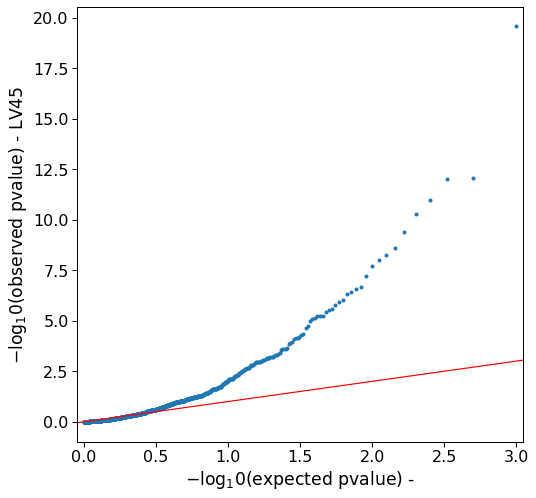

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.003738,0.012467,0.299878,0.764280,0.382140,random.pheno988
1220,LV234,-0.001726,0.012468,-0.138422,0.889911,0.555044,random.pheno589
2207,LV234,0.001255,0.012465,0.100660,0.919824,0.459912,random.pheno385
3194,LV234,0.012252,0.012466,0.982871,0.325708,0.162854,random.pheno5
4181,LV234,0.011398,0.012467,0.914241,0.360624,0.180312,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.085

In [42]:
show_prop(results, 0.05)

0.149

In [43]:
show_prop(results, 0.10)

0.203

In [44]:
show_prop(results, 0.15)

0.239

In [45]:
show_prop(results, 0.20)

0.281

### QQplot

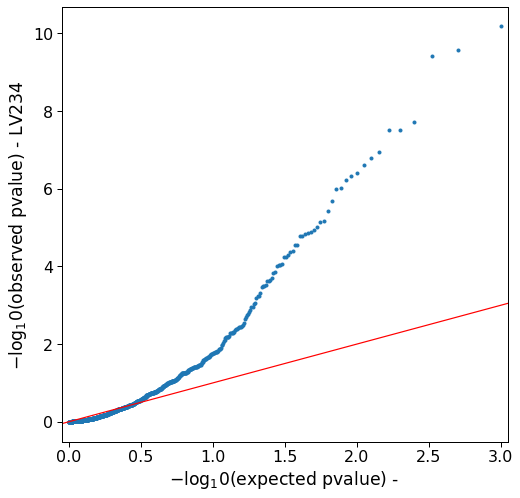

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,-0.004955,0.012469,-0.397406,0.691081,0.654459,random.pheno988
1833,LV847,0.001015,0.012471,0.081368,0.935152,0.467576,random.pheno589
2820,LV847,-0.004349,0.012467,-0.348865,0.727202,0.636399,random.pheno385
3807,LV847,0.007489,0.012469,0.600644,0.548099,0.274049,random.pheno5
4794,LV847,0.014240,0.012469,1.142016,0.253490,0.126745,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.089

In [53]:
show_prop(results, 0.05)

0.14

In [54]:
show_prop(results, 0.10)

0.19

In [55]:
show_prop(results, 0.15)

0.22

In [56]:
show_prop(results, 0.20)

0.255

### QQplot

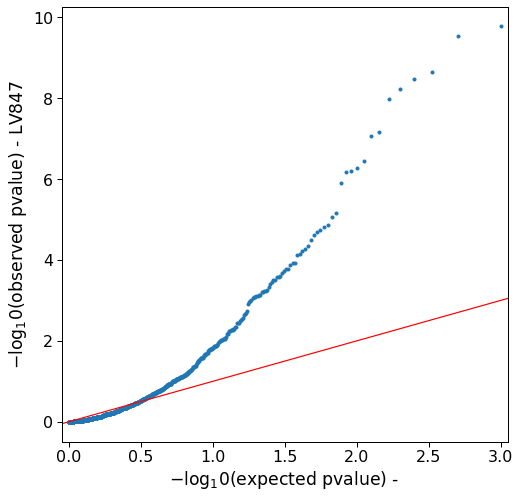

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.024956,0.012466,-2.001870,0.045341,0.977330,random.pheno988
1096,LV110,0.000373,0.012472,0.029890,0.976155,0.488078,random.pheno589
2083,LV110,-0.006149,0.012468,-0.493160,0.621917,0.689042,random.pheno385
3070,LV110,-0.006706,0.012470,-0.537774,0.590752,0.704624,random.pheno5
4057,LV110,0.009502,0.012471,0.761926,0.446132,0.223066,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.075

In [64]:
show_prop(results, 0.05)

0.122

In [65]:
show_prop(results, 0.10)

0.167

In [66]:
show_prop(results, 0.15)

0.208

In [67]:
show_prop(results, 0.20)

0.244

### QQplot

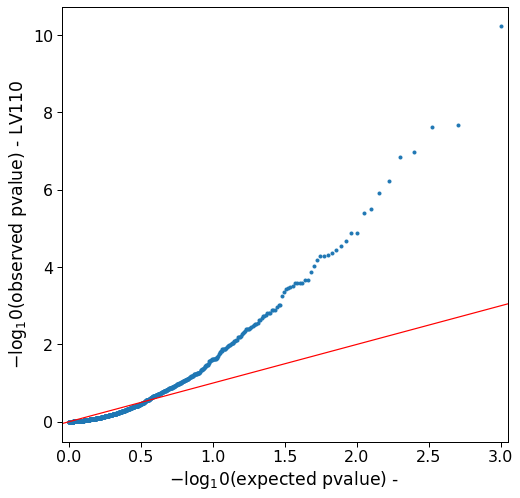

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.012257,0.012458,0.983858,0.325222,0.162611,random.pheno988
1755,LV769,0.001449,0.012460,0.116305,0.907415,0.453707,random.pheno589
2742,LV769,0.001860,0.012457,0.149293,0.881327,0.440663,random.pheno385
3729,LV769,-0.021273,0.012456,-1.707890,0.087705,0.956148,random.pheno5
4716,LV769,-0.019083,0.012458,-1.531825,0.125615,0.937193,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.037

In [75]:
show_prop(results, 0.05)

0.119

In [76]:
show_prop(results, 0.10)

0.198

In [77]:
show_prop(results, 0.15)

0.25

In [78]:
show_prop(results, 0.20)

0.303

### QQplot

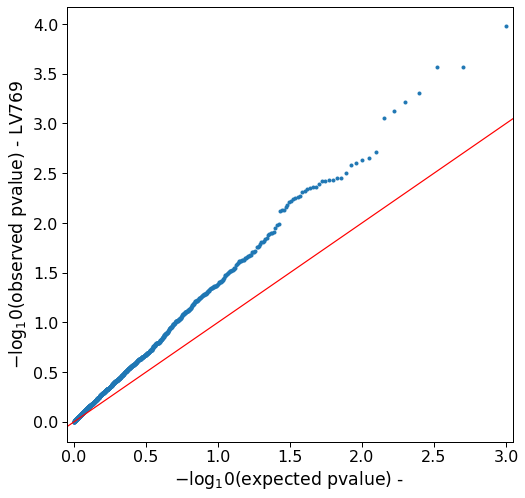

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.010764,0.012469,0.863266,0.388023,0.194012,random.pheno988
1786,LV800,0.002792,0.012471,0.223840,0.822889,0.411444,random.pheno589
2773,LV800,-0.011311,0.012467,-0.907307,0.364278,0.817861,random.pheno385
3760,LV800,-0.022516,0.012467,-1.806042,0.070958,0.964521,random.pheno5
4747,LV800,-0.009498,0.012470,-0.761663,0.446289,0.776855,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.048

In [86]:
show_prop(results, 0.05)

0.11

In [87]:
show_prop(results, 0.10)

0.178

In [88]:
show_prop(results, 0.15)

0.213

In [89]:
show_prop(results, 0.20)

0.257

### QQplot

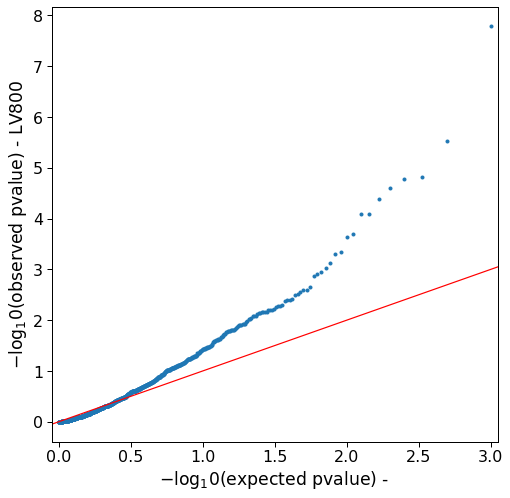

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
482,LV533,0.012,0.049,0.092
328,LV395,0.008,0.049,0.097
347,LV411,0.012,0.049,0.109
348,LV412,0.009,0.049,0.099
624,LV661,0.010,0.049,0.112
388,LV449,0.014,0.049,0.093
432,LV489,0.007,0.049,0.095
462,LV515,0.017,0.049,0.097
828,LV845,0.015,0.049,0.086
519,LV567,0.016,0.049,0.097


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.010528,0.012458,-0.845104,0.398084,0.800958,random.pheno988
1398,LV412,-0.015942,0.012459,-1.279565,0.200744,0.899628,random.pheno589
2385,LV412,0.019398,0.012454,1.557544,0.119390,0.059695,random.pheno385
3372,LV412,0.009564,0.012458,0.767645,0.442726,0.221363,random.pheno5
4359,LV412,0.010006,0.012459,0.803103,0.421945,0.210972,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.009

In [99]:
show_prop(results, 0.05)

0.049

In [100]:
show_prop(results, 0.10)

0.099

In [101]:
show_prop(results, 0.15)

0.141

In [102]:
show_prop(results, 0.20)

0.185

### QQplot

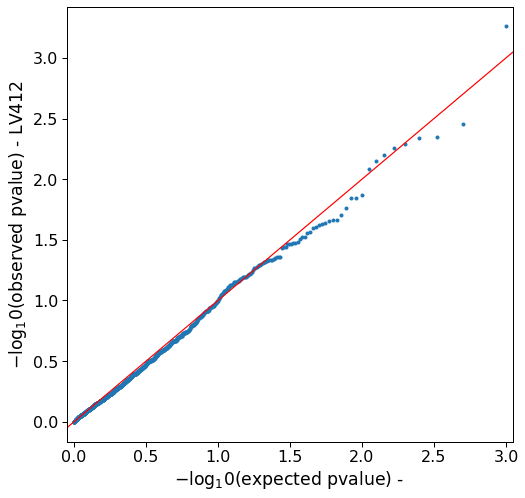

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020352,0.012459,-1.633508,0.102411,0.948794,random.pheno988
1043,LV57,0.023573,0.012460,1.891936,0.058544,0.029272,random.pheno589
2030,LV57,0.014754,0.012458,1.184297,0.236339,0.118170,random.pheno385
3017,LV57,-0.004017,0.012462,-0.322341,0.747205,0.626398,random.pheno5
4004,LV57,0.013832,0.012462,1.109927,0.267072,0.133536,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.011

In [110]:
show_prop(results, 0.05)

0.049

In [111]:
show_prop(results, 0.10)

0.091

In [112]:
show_prop(results, 0.15)

0.135

In [113]:
show_prop(results, 0.20)

0.182

### QQplot

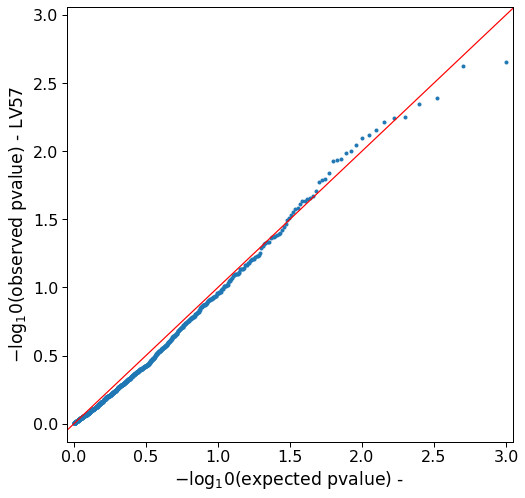

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007685,0.012472,-0.616199,0.537785,0.731108,random.pheno988
1633,LV647,0.000575,0.012474,0.046062,0.963262,0.481631,random.pheno589
2620,LV647,0.000384,0.012471,0.030786,0.975442,0.487721,random.pheno385
3607,LV647,0.004912,0.012472,0.393847,0.693707,0.346853,random.pheno5
4594,LV647,0.004765,0.012474,0.381971,0.702495,0.351248,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.01

In [121]:
show_prop(results, 0.05)

0.05

In [122]:
show_prop(results, 0.10)

0.09

In [123]:
show_prop(results, 0.15)

0.141

In [124]:
show_prop(results, 0.20)

0.182

### QQplot

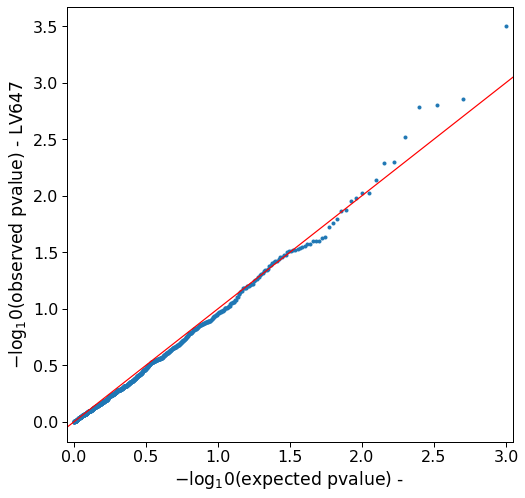

In [125]:
qqplot_unif(results)